# Classification analysis - Lasso regression

**Author:** M.G. Baltussen

This notebook performs weight training and plots results for a set of (nonlinear) classification tasks, using a Lasso Regression algorithm.

**Estimated running time:** 20 minutes

**Generated output:**
```
plots/classification_results_lasso.{svg,png}
plots/classification_results_scored_lasso.{svg,png}
plots_extended/classification_lasso_weights.{svg,png}
plots_extended/classification_lasso_weights_AND_OR.{svg,png}
plots_extended/classification_lasso_weights_XOR.{svg,png}
plots_extended/classification_lasso_progress_short_version.{svg,png}
plots_extended/classification_lasso_progress_0.{svg,png}
plots_extended/classification_lasso_progress_1.{svg,png}
plots_extended/classification_lasso_progress_2.{svg,png}
plots_extended/classification_lasso_progress_3.{svg,png}
plots_extended/classification_lasso_progress_4.{svg,png}
plots_extended/classification_lasso_progress_5.{svg,png}
```

## Imports

In [1]:
""" System imports """

import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns

sns.set_theme(
    style="ticks",
    context="paper",
    font_scale=0.75,
    rc={
        "axes.linewidth": 0.5,
        "axes.facecolor": "#eceff4",
        "axes.edgecolor": "#2e3440",
        "axes.labelcolor": "#2e3440",
        "text.color": "#2e3440",
        "xtick.color": "#2e3440",
        "ytick.color": "#2e3440",
        "font.family": "Arial",
        "svg.fonttype": "none",
    },
)
import colorcet as cc

nord_palette = [
    "#bf616a",
    "#d08770",
    "#ebcb8b",
    "#a3be8c",
    "#b48ead",
    "#8fbcbb",
    "#88c0d0",
    "#81a1c1",
    "#5e81ac",
    "#2e3440",
    "#3b4252",
    "#434c5e",
    "#4c566a",
    "#d8dee9",
    "#e5e9f0",
    "#eceff4",
]

sns.set_palette(nord_palette)


def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)


def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)

## Data loading

In [2]:
""" Load preprocessed data"""

df_all = pd.read_csv("../data/steadystates.csv", index_col=0)

U_chem = df_all[["NaOH", "Form"]].values
X_orig = df_all.drop(columns=["time", "NaOH", "Form", "exp"]).values

pad_frac = np.array([-0.05, 0.05])
ranges = np.array([[10, 50], [10, 150]])
pad = pad_frac * np.diff(ranges, axis=1)
extends = ranges + pad
x_extend = extends[0]
y_extend = extends[1]
U = (U_chem - extends[:, 0]) / (extends[:, 1] - extends[:, 0])

X = preprocessing.StandardScaler().fit_transform(X_orig)

## Classification task definitions

In [3]:
from collections import OrderedDict

""" Generating training labels from inputs """
y_xor = np.logical_xor(U[:, 0] < 0.5, U[:, 1] < 0.5)
y_circle = ((U[:, 0] - 0.5) ** 2 + (U[:, 1] - 0.5) ** 2) < 0.125
y_sin = U[:, 1] > 0.5 + 0.5 * np.sin(U[:, 0] * np.pi * 2 / 0.8 - np.pi / 4)

y_eye = 1 * (((U[:, 0] - 0.5) ** 2 + (U[:, 1] - 0.5) ** 2) < 0.16) - 1 * (
    ((U[:, 0] - 0.5) ** 2 + (U[:, 1] - 0.5) ** 2) < 0.04
)
y_dots = 1 * (((U[:, 0] - 0.3) ** 2 + (U[:, 1] - 0.3) ** 2) < 0.05) + 1 * (
    ((U[:, 0] - 0.7) ** 2 + (U[:, 1] - 0.7) ** 2) < 0.05
)


def triangle(x, y):
    z_triangle_b1 = y < x / 3 + 1 / 3
    z_triangle_b2 = x < y / 3 + 1 / 3
    z_triangle_b3 = y < -x + 1
    z_triangle_1 = -1 * np.logical_and(z_triangle_b1, z_triangle_b3)
    z_triangle_2 = 0.0 * np.logical_and(z_triangle_b2, ~z_triangle_b1)
    z_triangle_3 = np.logical_and(~z_triangle_b2, ~z_triangle_b3)
    z_triangle = z_triangle_1 + z_triangle_2 + z_triangle_3
    return z_triangle


y_linear = U[:, 1] > U[:, 0]
y_and = np.logical_and(U[:, 0] > 0.5, U[:, 1] > 0.5)
y_or = np.logical_or(U[:, 0] > 0.5, U[:, 1] > 0.5)
y_triangle = triangle(U[:, 0], U[:, 1])
y_checker = np.logical_xor((U[:, 0] // 0.33333) % 2, (U[:, 1] // 0.33333) % 2)

y_train_linear = OrderedDict(
    Linear=y_linear,
    AND=y_and,
    OR=y_or,
    Triangle=y_triangle,
    Checkers=y_checker,
)

y_train = OrderedDict(
    AND=y_and,
    OR=y_or,
    Linear=y_linear,
    Triangle=y_triangle,
    XOR=y_xor,
    Checkers=y_checker,
    Circle=y_circle,
    Sine=y_sin,
    Concentric=y_eye,
    Dots=y_dots,
)

## Training and plots figure 2b

In [4]:
""" Generating background color-grids """

N_POINTS = 1000
xx = np.linspace(*x_extend, N_POINTS)
yy = np.linspace(*y_extend, N_POINTS)
xs, ys = np.meshgrid(np.linspace(0, 1.0, N_POINTS), np.linspace(0, 1.0, N_POINTS))

z_xor = np.logical_xor(xs < 0.5, ys < 0.5)
z_circle = ((xs - 0.5) ** 2 + (ys - 0.5) ** 2) < 0.125
z_eye = 1 * (((xs - 0.5) ** 2 + (ys - 0.5) ** 2) < 0.16) - 1 * (
    ((xs - 0.5) ** 2 + (ys - 0.5) ** 2) < 0.04
)
z_dots = 1 * (((xs - 0.3) ** 2 + (ys - 0.3) ** 2) < 0.05) + 1 * (
    ((xs - 0.7) ** 2 + (ys - 0.7) ** 2) < 0.05
)
z_sin = ys > 0.5 + 0.5 * np.sin(xs * np.pi * 2 / 0.8 - np.pi / 4)


z_linear = ys > xs
z_and = np.logical_and(xs > 0.5, ys > 0.5)
z_or = np.logical_or(xs > 0.5, ys > 0.5)
z_triangle = triangle(xs, ys)
z_checker = np.logical_xor((xs // 0.33333) % 2, (ys // 0.33333) % 2)

z_train_linear = OrderedDict(
    Linear=z_linear,
    AND=z_and,
    OR=z_or,
    Triangle=z_triangle,
    Checkers=z_checker,
)

z_train = OrderedDict(
    AND=z_and,
    OR=z_or,
    Linear=z_linear,
    Triangle=z_triangle,
    XOR=z_xor,
    Checkers=z_checker,
    Circle=z_circle,
    Sine=z_sin,
    Concentric=z_eye,
    Dots=z_dots,
)

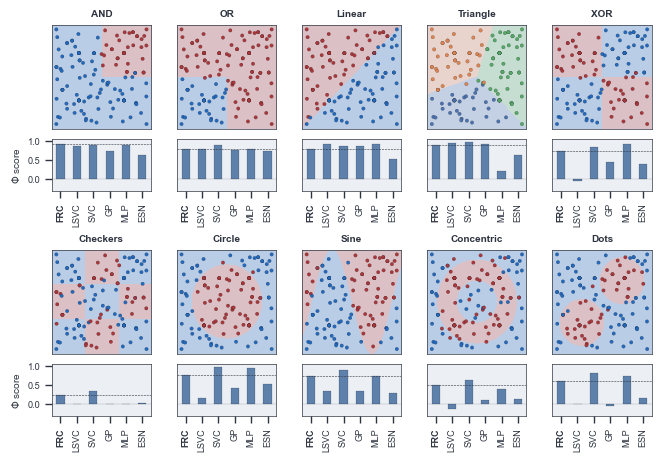

In [5]:
""" Nonlinear classification examples 
Perform training, L5O-CV and plotting 
for every classification task defined above
"""

titledict = {"fontweight": "bold"}

from sklearn import neighbors, gaussian_process, tree, neural_network


classifiers = {
    "LSVC": svm.LinearSVC(max_iter=50_000, tol=1e-4, dual=False, penalty="l1", C=0.5),
    "SVC": svm.SVC(max_iter=50_000, tol=1e-4),
    "GP": gaussian_process.GaussianProcessClassifier(),
    "MLP": neural_network.MLPClassifier(max_iter=100_000),
    "ESN": ESNClassifier(regressor=linear_model.Ridge()),
}

classifier_labels = ["FRC"] + list(classifiers.keys())
N_classifiers = len(classifiers)
N_tasks = len(z_train)
fig, axes = plt.subplots(
    4,
    5,
    figsize=(6.5, 4.5),
    constrained_layout=True,
    gridspec_kw={"hspace": -0.25, "wspace": 0.2, "height_ratios": [2, 1, 2, 1]},
)

axes = np.hstack((axes[:2], axes[2:]))

fit_times = OrderedDict()
coefficients = OrderedDict()
for i, (k, v) in enumerate(z_train.items()):
    axes[1, i].axhline(0, color="C9", lw=0.1)

    reg = svm.LinearSVC(max_iter=50_000, tol=1e-4, dual=False, penalty="l1", C=0.5)
    y = y_train[k]
    scores = model_selection.cross_validate(
        reg,
        X,
        y,
        scoring=metrics.make_scorer(metrics.matthews_corrcoef),
        cv=model_selection.RepeatedStratifiedKFold(n_splits=132 // 5, n_repeats=20),
        n_jobs=10,
        return_train_score=True,
    )

    reg.fit(X, y)
    y_predict = reg.predict(X)
    train_score = reg.score(X, y)

    if (k == "Triangle") | (k == "Cluster"):
        cmap_triangle = mpl.colors.ListedColormap(sns.color_palette("deep", n_colors=3))
        norm = mpl.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], 3)
        axes[0, i].imshow(
            v,
            origin="lower",
            aspect="auto",
            interpolation="none",
            extent=(*x_extend, *y_extend),
            alpha=0.25,
            cmap=cmap_triangle,
            norm=norm,
        )
        axes[0, i].scatter(
            *U_chem.T,
            ec="black",
            lw=0.1,
            s=(2.5**2),
            c=y_predict,
            cmap=cmap_triangle,
            norm=norm,
        )
    else:
        axes[0, i].imshow(
            v,
            origin="lower",
            aspect="auto",
            interpolation="none",
            extent=(*x_extend, *y_extend),
            alpha=0.25,
            cmap=sns.color_palette("vlag", as_cmap=True),
        )
        axes[0, i].scatter(
            *U_chem.T,
            ec="black",
            lw=0.1,
            s=(2.5**2),
            c=y_predict,
            cmap=sns.color_palette("vlag", as_cmap=True),
        )

    axes[0, i].set_title(k, fontdict=titledict)
    axes[0, i].set_xlim(*x_extend)
    axes[0, i].set_ylim(*y_extend)
    axes[0,i].set_xticks([10, 50], [10, 50])
    axes[0,i].set_yticks([10, 150], [10, 150])
    axes[0,i].set_xlabel(r"NaOH ($mM$)", fontsize=6)
    axes[0,i].set_ylabel(r"Form. ($mM$)", fontsize=6)
    axes[0,i].xaxis.set_label_coords(0.5, -0.1)
    axes[0,i].yaxis.set_label_coords(-0.1, 0.5)

    axy = axes[0,i].twiny()
    axy.set_xticks([0, 1])
    axy.set_xlim(-0.05, 1.05)
    axy.set_xlabel(r"$u_0$")

    axx = axes[0,i].twinx()
    axx.set_yticks([0, 1])
    axx.set_ylim(-0.05, 1.05)
    axx.set_ylabel(r"$u_1$")
    axy.xaxis.set_label_coords(0.5, 1.1)
    axx.yaxis.set_label_coords(1.1, 0.5)

    train_scores = [train_score]
    fit_times[k] = [scores["fit_time"].mean()]
    coefficients[k] = reg.coef_
    test_scores = [scores["test_score"].mean()]
    test_scores_std = [scores["test_score"].std()]
    for name, clf in classifiers.items():
        scores = model_selection.cross_validate(
            clf,
            U,
            y,
            scoring=metrics.make_scorer(metrics.matthews_corrcoef),
            cv=model_selection.RepeatedStratifiedKFold(n_splits=132 // 5, n_repeats=20),
            n_jobs=10,
            return_train_score=True,
        )
        clf.fit(U, y)
        y_predict = clf.predict(U)
        train_score = clf.score(U, y.astype(int))
        train_scores.append(train_score)
        fit_times[k].append(scores["fit_time"].mean())
        test_scores.append(scores["test_score"].mean())
        test_scores_std.append(scores["test_score"].std())
    axes[1, i].bar(
        np.arange(0, N_classifiers + 1),
        width=0.5,
        height=test_scores,
        linewidth=0.1,
        edgecolor="0.0",
        ecolor="0.0",
        color="C8",
        label=classifier_labels,
    )
    axes[1, i].set_xticks(np.arange(0, N_classifiers + 1))
    axes[1, i].set_xticklabels(classifier_labels, rotation="vertical", ha="center")
    axes[1, i].get_xticklabels()[0].set_weight("bold")

    axes[1, i].set_ylim(-0.3, 1.05)
    axes[1, i].set_yticks([])
    axes[1, i].axhline(test_scores[0], ls="--", lw=0.4, color="C9")

axes[1, 0].set_yticks([0, 0.5, 1.0])
axes[1, 0].set_ylabel(r"$\Phi$ score")
axes[1, 5].set_yticks([0, 0.5, 1.0])
axes[1, 5].set_ylabel(r"$\Phi$ score")

save_si("classification_results_lasso")
plt.show()

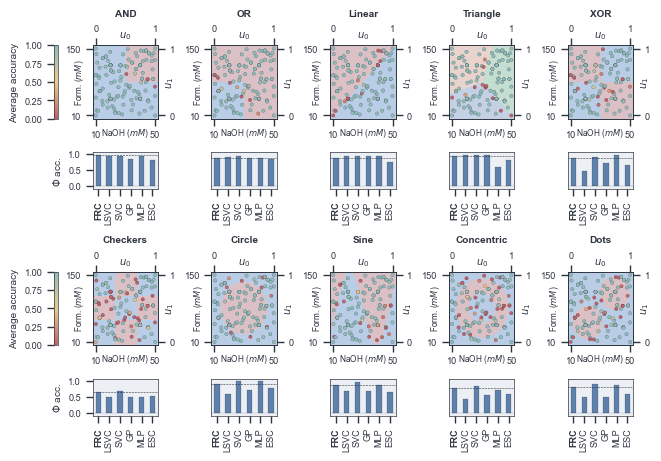

In [18]:
""" Nonlinear classification examples 
Perform training, L5O-CV and plotting 
for every classification task defined above
"""

titledict = {"fontweight": "bold"}

from sklearn import neighbors, gaussian_process, tree, neural_network


classifiers = {
    "LSVC": svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=False, penalty="l1", C=0.5),
    "SVC": svm.SVC(max_iter=10_000, tol=1e-4),
    "GP": gaussian_process.GaussianProcessClassifier(),
    "MLP": neural_network.MLPClassifier(max_iter=100_000),
    "ESC": ESNClassifier(
        regressor=linear_model.Ridge(),
    ),
}

classifier_labels = ["FRC"] + list(classifiers.keys())
N_classifiers = len(classifiers)
N_tasks = len(z_train)
fig, axes = plt.subplots(
    4,
    5,
    figsize=(6.5, 4.5),
    constrained_layout=True,
    gridspec_kw={"hspace": 0.1, "wspace": 0.0, "height_ratios": [2, 1, 2, 1]},
)

axes = np.hstack((axes[:2], axes[2:]))

fit_times = OrderedDict()
test_scores = OrderedDict()
test_scores_std = OrderedDict()
coefficients = OrderedDict()

for i, (k, v) in enumerate(z_train.items()):
    axes[1, i].axhline(0, color="C9", lw=0.1)

    reg = svm.LinearSVC(max_iter=50_000, tol=1e-4, dual=False, penalty="l1", C=0.5)
    y = y_train[k]
    scores = model_selection.cross_validate(
        reg,
        X,
        y,
        scoring=metrics.make_scorer(metrics.matthews_corrcoef),
        cv=model_selection.RepeatedStratifiedKFold(n_splits=132 // 5, n_repeats=20),
        n_jobs=10,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )

    estimators = np.array([est.predict(X) for est in scores["estimator"]])
    est_scores = np.equal(y, estimators).sum(axis=0) / estimators.shape[0]

    est_predictions = [
        est.predict(X[scores["indices"]["test"][i]])
        for i, est in enumerate(scores["estimator"])
    ]
    from collections import defaultdict

    est_predictions_by_idx = defaultdict(list)
    for e_i, (idxs, preds) in enumerate(
        zip(scores["indices"]["test"], est_predictions)
    ):
        for idx, pred in zip(idxs, preds):
            est_predictions_by_idx[idx].append(pred)

    est_scores_by_idx = {
        k: np.equal(y[k], v).mean() for k, v in est_predictions_by_idx.items()
    }
    idx = np.array(list(est_scores_by_idx.keys()))
    vals = np.array(list(est_scores_by_idx.values()))
    est_scores = np.zeros(X.shape[0])
    est_scores[idx] = vals

    reg.fit(X, y)
    y_predict = reg.predict(X)
    train_score = reg.score(X, y)

    cmap = sns.color_palette("blend:#BF616A,#EBCB8B,#8FBCBB", as_cmap=True, n_colors=10)
    if (k == "Triangle") | (k == "Cluster"):
        cmap_triangle = mpl.colors.ListedColormap(sns.color_palette("deep", n_colors=3))
        norm = mpl.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], 3)
        axes[0, i].imshow(
            v,
            origin="lower",
            aspect="auto",
            interpolation="none",
            extent=(*x_extend, *y_extend),
            alpha=0.25,
            cmap=cmap_triangle,
            norm=norm,
        )
        axes[0, i].scatter(
            *U_chem.T,
            s=(2.5**2),
            c=est_scores,
            lw=0.1,
            ec="black",
            zorder=10,
            cmap=cmap,
            norm=plt.Normalize(0, 1.0),
        )
    else:
        axes[0, i].imshow(
            v,
            origin="lower",
            aspect="auto",
            interpolation="none",
            extent=(*x_extend, *y_extend),
            alpha=0.25,
            cmap=sns.color_palette("vlag", as_cmap=True),
        )
        axes[0, i].scatter(
            *U_chem.T,
            s=(2.5**2),
            c=est_scores,
            lw=0.1,
            ec="black",
            zorder=10,
            cmap=cmap,
            norm=plt.Normalize(0.0, 1.0),
        )

    axes[0, i].set_title(k, fontdict=titledict)
    axes[0, i].set_xlim(*x_extend)
    axes[0, i].set_ylim(*y_extend)
    axes[0,i].set_xticks([10, 50], [10, 50])
    axes[0,i].set_yticks([10, 150], [10, 150])
    axes[0,i].set_xlabel(r"NaOH ($mM$)", fontsize=6)
    axes[0,i].set_ylabel(r"Form. ($mM$)", fontsize=6)
    axes[0,i].xaxis.set_label_coords(0.5, -0.1)
    axes[0,i].yaxis.set_label_coords(-0.1, 0.5)

    axy = axes[0,i].twiny()
    axy.set_xticks([0, 1])
    axy.set_xlim(-0.05, 1.05)
    axy.set_xlabel(r"$u_0$")

    axx = axes[0,i].twinx()
    axx.set_yticks([0, 1])
    axx.set_ylim(-0.05, 1.05)
    axx.set_ylabel(r"$u_1$")
    axy.xaxis.set_label_coords(0.5, 1.1)
    axx.yaxis.set_label_coords(1.1, 0.5)

    train_scores = [train_score]
    fit_times[k] = [scores["fit_time"].mean()]
    coefficients[k] = reg.coef_
    test_scores[k] = [scores["test_score"].mean()]
    test_scores_std[k] = [scores["test_score"].std()]
    for name, clf in classifiers.items():
        scores = model_selection.cross_validate(
            clf,
            U,
            y,
            scoring=metrics.make_scorer(metrics.matthews_corrcoef),
            cv=model_selection.RepeatedStratifiedKFold(n_splits=132 // 5, n_repeats=20),
            n_jobs=10,
            return_train_score=True,
        )
        clf.fit(U, y)
        y_predict = clf.predict(U)

        train_score = clf.score(U, y.astype(int))
        train_scores.append(train_score)
        fit_times[k].append(scores["fit_time"].mean())
        test_scores[k].append(scores["test_score"].mean())
        test_scores_std[k].append(scores["test_score"].std())
    axes[1, i].bar(
        np.arange(0, N_classifiers + 1),
        width=0.5,
        height=(np.array(test_scores[k]) + 1) / 2,
        linewidth=0.1,
        edgecolor="0.0",
        ecolor="0.0",
        color="C8",
        label=classifier_labels,
    )
    axes[1, i].set_xticks(np.arange(0, N_classifiers + 1))
    axes[1, i].set_xticklabels(classifier_labels, rotation="vertical", ha="center")
    axes[1, i].get_xticklabels()[0].set_weight("bold")

    axes[1, i].set_ylim(-0.1, 1.05)
    axes[1, i].set_yticks([])
    axes[1, i].axhline((test_scores[k][0] + 1) / 2, ls="--", lw=0.4, color="C9")

axes[1, 0].set_yticks([0, 0.5, 1.0])
axes[1, 0].set_ylabel(r"$\Phi$ acc.")
axes[1, 5].set_yticks([0, 0.5, 1.0])
axes[1, 5].set_ylabel(r"$\Phi$ acc.")

smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
cbar = fig.colorbar(smap, ax=axes[0, 0], location="left", pad=-0.1)
cbar.ax.set_ylabel("Average accuracy", rotation=90)

cbar = fig.colorbar(smap, ax=axes[0, 5], location="left", pad=-0.1)
cbar.ax.set_ylabel("Average accuracy", rotation=90)

save_si("classification_results_scored_lasso")
plt.show()

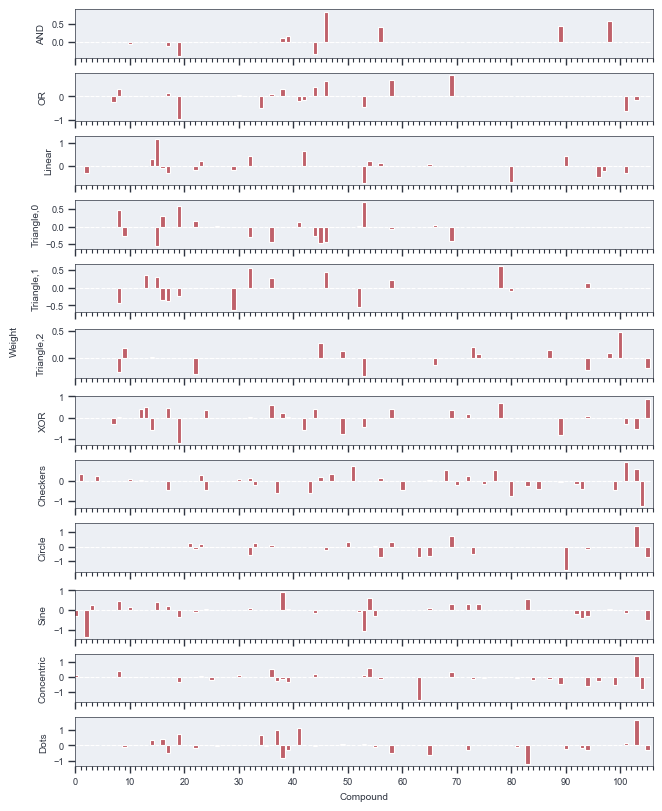

In [7]:
from matplotlib.ticker import MultipleLocator

coefficients_df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(
        [(k, i) for k, v in coefficients.items() for i, _ in enumerate(v)]
    ),
    data=[vi for k, v in coefficients.items() for vi in v],
)

fig, axes = plt.subplots(
    nrows=coefficients_df.shape[0],
    figsize=(6.3, 8),
    constrained_layout=True,
    sharex=True,
)
for i, (name, row) in enumerate(coefficients_df.iterrows()):
    axes[i].bar(np.arange(len(row)), row)
    axes[i].set_ylabel(name[0] if name[0] != "Triangle" else f"{name[0]},{name[1]}")
    axes[i].xaxis.set_minor_locator(MultipleLocator(1))
    axes[i].xaxis.set_major_locator(MultipleLocator(10))
    axes[i].set_xlim(0, 106)

fig.text(-0.02, 0.58, "Weight", va="center", ha="center", rotation=90)
axes[-1].set_xlabel("Compound")
save_si("classification_lasso_weights")
plt.show()

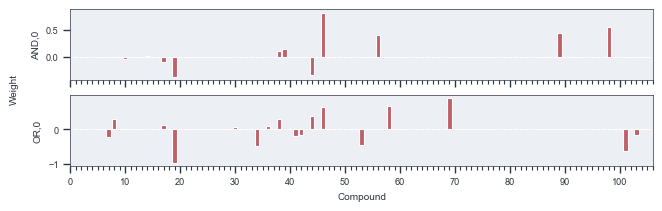

In [8]:
from matplotlib.ticker import MultipleLocator

coefficients_df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(
        [(k, i) for k, v in coefficients.items() for i, _ in enumerate(v)]
    ),
    data=[vi for k, v in coefficients.items() for vi in v],
).loc[["AND", "OR"]]

fig, axes = plt.subplots(
    nrows=coefficients_df.shape[0],
    figsize=(6.3, 2),
    constrained_layout=True,
    sharex=True,
)
for i, (name, row) in enumerate(coefficients_df.iterrows()):
    axes[i].bar(np.arange(len(row)), row)
    axes[i].set_ylabel(f"{name[0]},{name[1]}")
    axes[i].xaxis.set_minor_locator(MultipleLocator(1))
    axes[i].xaxis.set_major_locator(MultipleLocator(10))
    axes[i].set_xlim(0, 106)

fig.text(-0.02, 0.58, "Weight", va="center", ha="center", rotation=90)
axes[1].set_xlabel("Compound")
save_si("classification_lasso_weights_AND_OR")
plt.show()

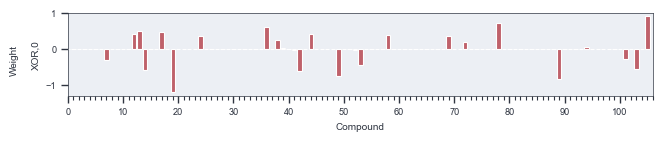

In [9]:
from matplotlib.ticker import MultipleLocator

coefficients_df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(
        [(k, i) for k, v in coefficients.items() for i, _ in enumerate(v)]
    ),
    data=[vi for k, v in coefficients.items() for vi in v],
).loc[["XOR"]]

fig, axes = plt.subplots(
    figsize=(6.3, 1.3),
    constrained_layout=True,
    sharex=True,
)
for i, (name, row) in enumerate(coefficients_df.iterrows()):
    axes.bar(np.arange(len(row)), row)
    axes.set_ylabel(f"{name[0]},{name[1]}")
    axes.xaxis.set_minor_locator(MultipleLocator(1))
    axes.xaxis.set_major_locator(MultipleLocator(10))
    axes.set_xlim(0, 106)

fig.text(-0.02, 0.58, "Weight", va="center", ha="center", rotation=90)
axes.set_xlabel("Compound")
save_si("classification_lasso_weights_XOR")
plt.show()

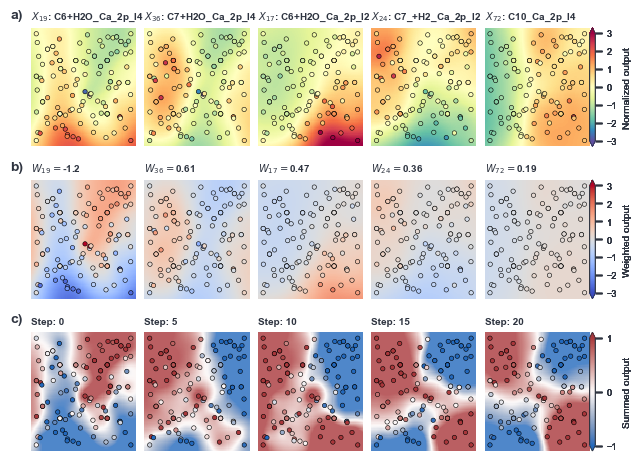

In [10]:
from scipy.interpolate import RBFInterpolator

species = df_all.drop(columns=["time", "NaOH", "Form", "exp"]).columns

XOR_weights_abs = abs(coefficients["XOR"][0])
XOR_weights_idx_sorted = XOR_weights_abs.argsort()[::-1]

N_POINTS = 100
mgrid = np.meshgrid(np.linspace(0, 1.0, N_POINTS), np.linspace(0, 1.0, N_POINTS))
grid = np.array(mgrid).reshape(2, -1).T
Y = X * coefficients["XOR"]
Z = Y[:, XOR_weights_idx_sorted].cumsum(axis=1)

fig, axes = plt.subplots(
    3,
    5,
    figsize=(6.3, 4.5),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"hspace": 0.1},
)

for j in range(5):
    i = 0
    idx = XOR_weights_idx_sorted[i + j * 5]

    rbf = RBFInterpolator(U, X[:, idx], smoothing=0.1)
    ZI = rbf(grid)

    axes[0, j].pcolormesh(
        mgrid[0],
        mgrid[1],
        ZI.reshape(100, 100),
        shading="nearest",
        cmap="Spectral_r",
        vmin=-3,
        vmax=3,
    )
    axes[0, j].scatter(
        U[:, 0],
        U[:, 1],
        s=10,
        c=X[:, idx],
        cmap="Spectral_r",
        vmin=-3,
        vmax=3,
        edgecolor="black",
        lw=0.4,
    )

    axes[0, j].set_title(
        r"$X_{" + f"{idx}" + "}$" + f": {species[idx]}",
        loc="left",
        fontdict={"fontweight": "bold"},
    )
    axes[0, j].set_axis_off()

    rbf = RBFInterpolator(U, Y[:, idx], smoothing=0.1)
    ZI = rbf(grid)

    axes[1, j].pcolormesh(
        mgrid[0],
        mgrid[1],
        ZI.reshape(100, 100),
        shading="nearest",
        cmap="coolwarm",
        vmin=-3,
        vmax=3,
    )
    axes[1, j].scatter(
        U[:, 0],
        U[:, 1],
        s=10,
        c=Y[:, idx],
        cmap="coolwarm",
        vmin=-3,
        vmax=3,
        edgecolor="black",
        lw=0.4,
    )

    axes[1, j].set_title(
        r"$W_{" + f"{idx}" + "} = $" + f"{coefficients['XOR'][0,idx]:.02}",
        loc="left",
        fontdict={"fontweight": "bold"},
    )
    axes[1, j].set_axis_off()

    rbf = RBFInterpolator(U, Z[:, i + j * 5], kernel="linear", smoothing=0.1)
    ZI = rbf(grid)

    axes[2, j].pcolormesh(
        mgrid[0],
        mgrid[1],
        ZI.reshape(100, 100),
        shading="nearest",
        cmap="vlag",
        vmin=-1,
        vmax=1,
        alpha=0.8,
    )
    axes[2, j].scatter(
        U[:, 0],
        U[:, 1],
        s=10,
        c=Z[:, i + j * 5],
        cmap="vlag",
        vmin=-1,
        vmax=1,
        edgecolor="black",
        lw=0.4,
    )

    axes[2, j].set_title(
        f"Step: {i + j*5}", loc="left", fontdict={"fontweight": "bold"}
    )
    axes[2, j].set_axis_off()

    cax1 = axes[0, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
    cbar = fig.colorbar(
        cax=cax1,
        mappable=ScalarMappable(
            cmap=sns.color_palette("Spectral_r", as_cmap=True),
            norm=Normalize(vmin=-3, vmax=3),
        ),
        extend="both",
        orientation="vertical",
        location="right",
        shrink=1,
        ticks=[-3, -2, -1, 0, 1, 2, 3],
    )
    cbar.ax.set_ylabel("Normalized output", rotation=90)

    cax2 = axes[1, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
    cbar = fig.colorbar(
        cax=cax2,
        mappable=ScalarMappable(
            cmap=sns.color_palette("coolwarm", as_cmap=True),
            norm=Normalize(vmin=-3, vmax=3),
        ),
        extend="both",
        orientation="vertical",
        location="right",
        shrink=1,
        ticks=[-3, -2, -1, 0, 1, 2, 3],
    )
    cbar.ax.set_ylabel("Weighted output", rotation=90)

    cax3 = axes[2, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
    cbar = fig.colorbar(
        cax=cax3,
        mappable=ScalarMappable(
            cmap=sns.color_palette("vlag", as_cmap=True),
            norm=Normalize(vmin=-1, vmax=1),
        ),
        extend="both",
        orientation="vertical",
        location="right",
        shrink=1,
        ticks=[-1, 0, 1],
    )
    cbar.ax.set_ylabel("Summed output", rotation=90)


axes[0, 0].text(
    -0.2, 1.08, "a)", transform=axes[0, 0].transAxes, weight="bold", size=10
)
axes[1, 0].text(
    -0.2, 1.08, "b)", transform=axes[1, 0].transAxes, weight="bold", size=10
)
axes[2, 0].text(
    -0.2, 1.08, "c)", transform=axes[2, 0].transAxes, weight="bold", size=10
)

save_si(f"classification_lasso_progress_short_version")

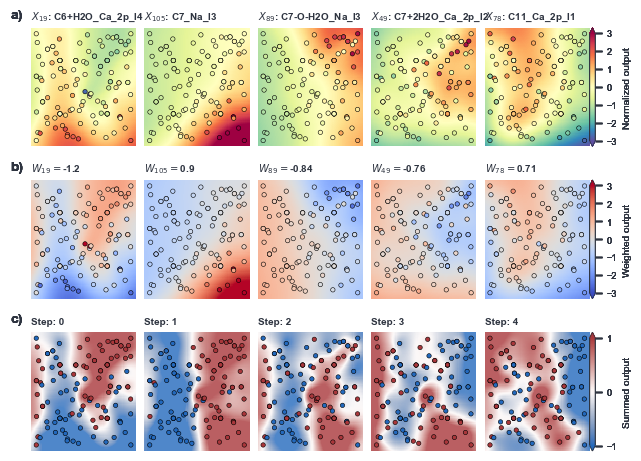

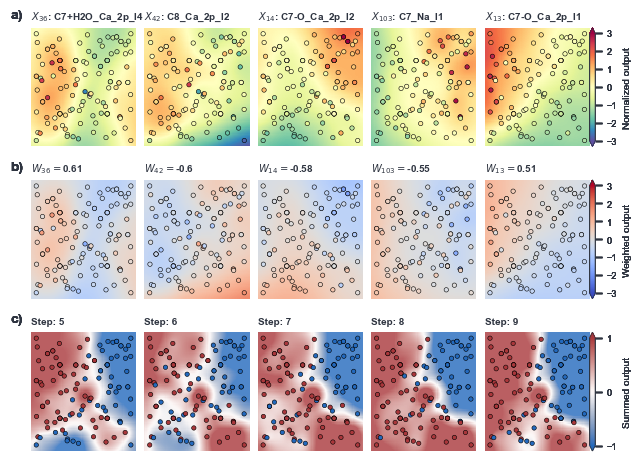

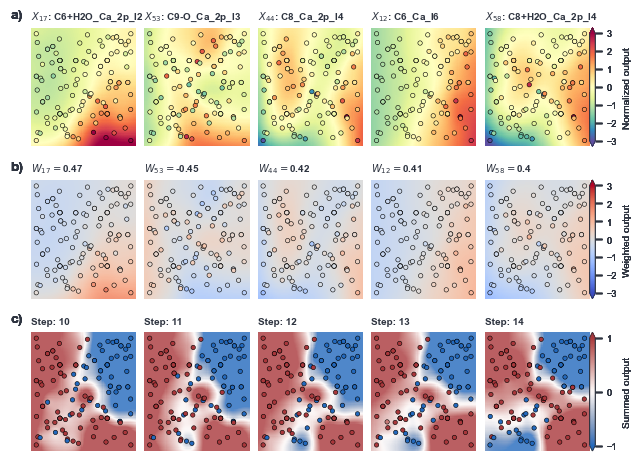

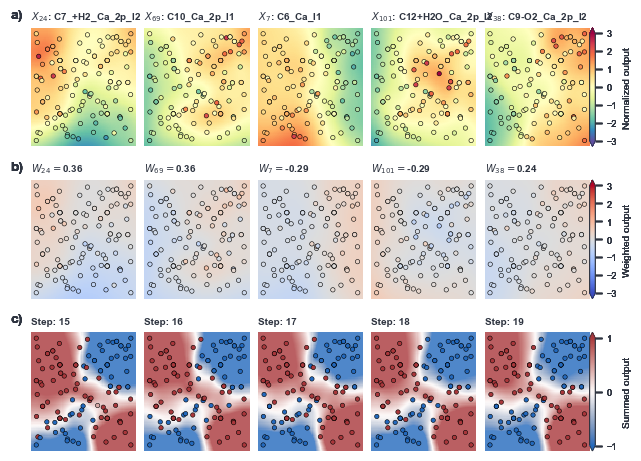

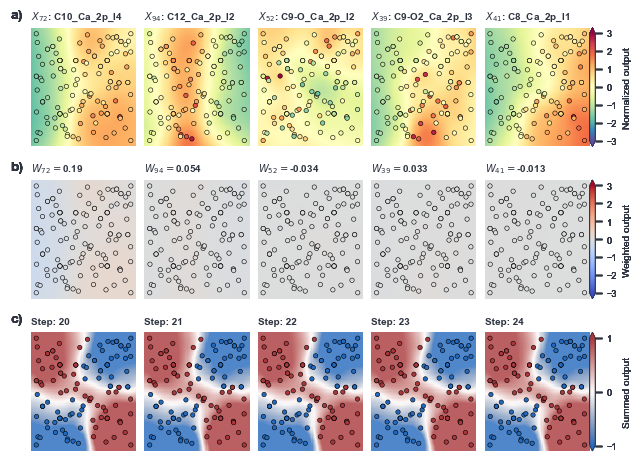

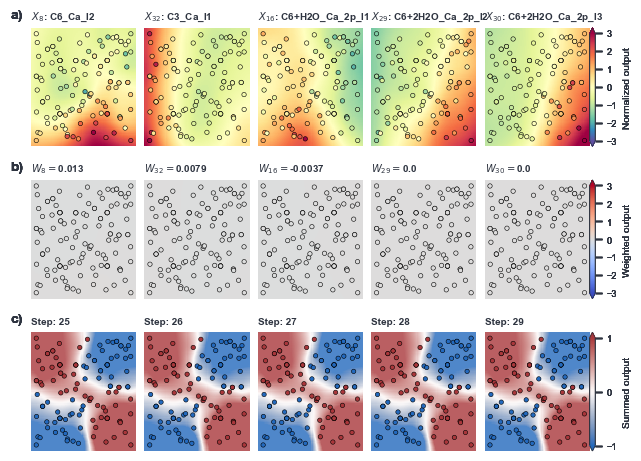

In [11]:
from scipy.interpolate import RBFInterpolator

species = df_all.drop(columns=["time", "NaOH", "Form", "exp"]).columns

XOR_weights_abs = abs(coefficients["XOR"][0])
XOR_weights_idx_sorted = XOR_weights_abs.argsort()[::-1]

N_POINTS = 100
mgrid = np.meshgrid(np.linspace(0, 1.0, N_POINTS), np.linspace(0, 1.0, N_POINTS))
grid = np.array(mgrid).reshape(2, -1).T
Y = X * coefficients["XOR"]
Z = Y[:, XOR_weights_idx_sorted].cumsum(axis=1)

for j in range(6):
    fig, axes = plt.subplots(
        3,
        5,
        figsize=(6.3, 4.5),
        sharex=True,
        sharey=True,
        constrained_layout=True,
        gridspec_kw={"hspace": 0.1},
    )

    for i in range(5):
        idx = XOR_weights_idx_sorted[i + j * 5]

        rbf = RBFInterpolator(U, X[:, idx], smoothing=0.1)
        ZI = rbf(grid)

        axes[0, i].pcolormesh(
            mgrid[0],
            mgrid[1],
            ZI.reshape(100, 100),
            shading="nearest",
            cmap="Spectral_r",
            vmin=-3,
            vmax=3,
        )
        axes[0, i].scatter(
            U[:, 0],
            U[:, 1],
            s=10,
            c=X[:, idx],
            cmap="Spectral_r",
            vmin=-3,
            vmax=3,
            edgecolor="black",
            lw=0.4,
        )

        axes[0, i].set_title(
            r"$X_{" + f"{idx}" + "}$" + f": {species[idx]}",
            loc="left",
            fontdict={"fontweight": "bold"},
        )
        axes[0, i].set_axis_off()

        rbf = RBFInterpolator(U, Y[:, idx], smoothing=0.1)
        ZI = rbf(grid)

        axes[1, i].pcolormesh(
            mgrid[0],
            mgrid[1],
            ZI.reshape(100, 100),
            shading="nearest",
            cmap="coolwarm",
            vmin=-3,
            vmax=3,
        )
        axes[1, i].scatter(
            U[:, 0],
            U[:, 1],
            s=10,
            c=Y[:, idx],
            cmap="coolwarm",
            vmin=-3,
            vmax=3,
            edgecolor="black",
            lw=0.4,
        )

        axes[1, i].set_title(
            r"$W_{" + f"{idx}" + "} = $" + f"{coefficients['XOR'][0,idx]:.02}",
            loc="left",
            fontdict={"fontweight": "bold"},
        )
        axes[1, i].set_axis_off()

        rbf = RBFInterpolator(U, Z[:, i + j * 5], kernel="linear", smoothing=0.1)
        ZI = rbf(grid)

        axes[2, i].pcolormesh(
            mgrid[0],
            mgrid[1],
            ZI.reshape(100, 100),
            shading="nearest",
            cmap="vlag",
            vmin=-1,
            vmax=1,
            alpha=0.8,
        )
        axes[2, i].scatter(
            U[:, 0],
            U[:, 1],
            s=10,
            c=Z[:, i + j * 5],
            cmap="vlag",
            vmin=-0.001,
            vmax=0.001,
            edgecolor="black",
            lw=0.4,
        )

        axes[2, i].set_title(
            f"Step: {i + j*5}", loc="left", fontdict={"fontweight": "bold"}
        )
        axes[2, i].set_axis_off()

        cax1 = axes[0, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
        cbar = fig.colorbar(
            cax=cax1,
            mappable=ScalarMappable(
                cmap=sns.color_palette("Spectral_r", as_cmap=True),
                norm=Normalize(vmin=-3, vmax=3),
            ),
            extend="both",
            orientation="vertical",
            location="right",
            shrink=1,
            ticks=[-3, -2, -1, 0, 1, 2, 3],
        )
        cbar.ax.set_ylabel("Normalized output", rotation=90)

        cax2 = axes[1, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
        cbar = fig.colorbar(
            cax=cax2,
            mappable=ScalarMappable(
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                norm=Normalize(vmin=-3, vmax=3),
            ),
            extend="both",
            orientation="vertical",
            location="right",
            shrink=1,
            ticks=[-3, -2, -1, 0, 1, 2, 3],
        )
        cbar.ax.set_ylabel("Weighted output", rotation=90)

        cax3 = axes[2, 4].inset_axes([1.0, 0.0, 0.05, 1.0])
        cbar = fig.colorbar(
            cax=cax3,
            mappable=ScalarMappable(
                cmap=sns.color_palette("vlag", as_cmap=True),
                norm=Normalize(vmin=-1, vmax=1),
            ),
            extend="both",
            orientation="vertical",
            location="right",
            shrink=1,
            ticks=[-1, 0, 1],
        )
        cbar.ax.set_ylabel("Summed output", rotation=90)
        axes[0, 0].text(
            -0.2, 1.08, "a)", transform=axes[0, 0].transAxes, weight="bold", size=10
        )
        axes[1, 0].text(
            -0.2, 1.08, "b)", transform=axes[1, 0].transAxes, weight="bold", size=10
        )
        axes[2, 0].text(
            -0.2, 1.08, "c)", transform=axes[2, 0].transAxes, weight="bold", size=10
        )

        save_si(f"classification_lasso_progress_{j}")